In [3]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras                              
from keras.models import Sequential  
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D    
from keras import backend as K                   
from keras.callbacks import Callback             
from keras.layers import Lambda, Input, Dense, Concatenate ,Conv2DTranspose 
from keras.layers import LeakyReLU,BatchNormalization,AveragePooling2D,Reshape 
from keras.layers import UpSampling2D,ZeroPadding2D
from keras.losses import mse, binary_crossentropy                           
from keras.models import Model                                                     
from keras.preprocessing.image import apply_transform, transform_matrix_offset_center
from sklearn.model_selection import train_test_split                                                                                                              
import numpy as np  
import cv2
import argparse     
import glob
import tensorflow as tf 



Using TensorFlow backend.


In [6]:
    
# In[27]:
image_root_path = '/nas/home/zekunl/dornsife/sub_maps_masks'
list_path = '/nas/home/zekunl/dornsife/train_val_split/USGS_val_test.list'
f = open(list_path,'r') 
file_list = f.read().splitlines() 
f.close()






In [8]:
# get the full path of map & maks files
X,Y = [],[]
for file_name in file_list:
    x = glob.glob( image_root_path + '/' + file_name.split('.jpg')[0] + '*.jpg'  )
    X.extend(x)

    # mask images (should search for corresponding images, NOT to use glob AGAIN!)
    # mask images
    y = []
    for patch_path in x:
        # patch_path eg: '/nas/home/zekunl/dornsife/sub_maps_masks/101201496_h9w8.jpg'
        base_name = os.path.basename(patch_path) # eg: 101201496_h9w8.jpg 
        this_mask_name = image_root_path + '/' + 'masked_' + base_name 
        y.append(this_mask_name)
    Y.extend(y) 
print 'num_samples = ',len(X)

num_samples =  327


In [ ]:
from keras.models import load_model
#mymodel = load_model('/nas/home/zekunl/dornsife/attempt_03_softmax08-0.19.hdf5')
mymodel = load_model('/nas/home/zekunl/dornsife/attempt_04_softmax08-0.20.hdf5')

In [107]:
avg_precision = 0
avg_recall = 0

for map_path,mask_path in zip(X,Y):        
    # rad map and masks
    map_img =  cv2.imread(map_path) 
    map_img = map_img / 255.

    mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) # read grayscale, 

    thresh = 100 # (values are only 0 and 150)
    bw_img = cv2.threshold(mask_img, thresh, 255, cv2.THRESH_BINARY)[1]
    proba_map = bw_img / 255.   # 0s and 1s
    
    map_img = np.expand_dims(map_img, axis = 0)

    predicted_y = mymodel.predict(map_img)
    predicted_y = predicted_y[0][:,:,0]
    #print predicted_y.shape, proba_map.shape
    
    thresh = 0.45
    img4 = np.zeros((predicted_y.shape[0],predicted_y.shape[1]))
    img4[predicted_y > thresh] = 1
    img4[predicted_y <= thresh] = 0
    img4 = img4.astype('uint8')
    
    index_one = np.where(img4 == 1)[0]    
    index_two = np.where(img4 == 1)[1]
    print index_one.shape
    print index_two.shape
    tp = 0
    for index1, index2 in zip(index_one, index_two):
        if img4[index1][index2] == proba_map[index1][index2]:
            tp += 1
        else:
            fp +=1
    if index_one.shape[0] != 0:
        precision = tp * 1.0 / index_one.shape[0]
        avg_precision  += precision
        print 'precision',precision


    
    index1_one = np.where(proba_map == 1)[0]    
    index1_two = np.where(proba_map == 1)[1]
    tp = 0
    for index1, index2 in zip(index1_one, index1_two):
        if img4[index1][index2] == proba_map[index1][index2]:
            tp += 1
        else:
            fp +=1
    if index1_one.shape[0] != 0:
        recall = tp * 1.0 / index1_one.shape[0]
        avg_recall += recall
        print 'recall',recall
    
    break
    

print avg_precision
print avg_recall

(12928,)
(12928,)
precision 0.510983910891
recall 0.542008532983
0.510983910891
0.542008532983


In [118]:
avg_precision = 0
avg_recall = 0
count1 = 0
count2 = 0

for map_path,mask_path in zip(X,Y):        
    # rad map and masks
    map_img =  cv2.imread(map_path) 
    map_img = map_img / 255.

    mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) # read grayscale, 

    thresh = 100 # (values are only 0 and 150)
    bw_img = cv2.threshold(mask_img, thresh, 255, cv2.THRESH_BINARY)[1]
    proba_map = bw_img / 255.   # 0s and 1s
    
    map_img = np.expand_dims(map_img, axis = 0)

    predicted_y = mymodel.predict(map_img)
    predicted_y = predicted_y[0][:,:,0]
    #print predicted_y.shape, proba_map.shape
    
    thresh = 0.55
    img4 = np.zeros((predicted_y.shape[0],predicted_y.shape[1]))
    img4[predicted_y > thresh] = 1
    img4[predicted_y <= thresh] = 0
    img4 = img4.astype('uint8')
    

    if img4[np.where(img4 == 1)].shape[0] != 0:
        precision = 1.0 * np.sum(img4[np.where(img4 == 1)] == proba_map[np.where(img4 == 1)] )/ img4[np.where(img4 == 1)].shape[0]
        avg_precision += precision
        count1 += 1
    if  proba_map[np.where(proba_map == 1)].shape[0]  != 0:
        recall = 1.0 * np.sum(img4[np.where(proba_map == 1)] == proba_map[np.where(proba_map == 1)] )/ proba_map[np.where(proba_map == 1)].shape[0]
        avg_recall += recall 
        count2 += 1
    
    print precision, recall

print avg_precision * 1.0 / count1
print avg_recall * 1.0 /count2

0.442176870748 0.0213324581556
0.694591904446 0.0828239669258
0.194049401198 0.0905874645119
0.419818456884 0.0286170980716
0.637107776262 0.0586793993843
0.606073752711 0.108204403307
0.165562913907 0.00604924082028
0.134179821551 0.0635333306252
0.0 0.0
1.0 0.0365155677656
0.679487179487 0.0957378177283
0.312558139535 0.039048200122
0.222345510413 0.022507344047
0.0 0.0
0.0 0.0
0.0 0.0
0.624556737589 0.362645847632
0.885964912281 0.205884959674
0.808181818182 0.64336372847
0.97597768714 0.214708909532
0.97597768714 0.0
0.187692307692 0.0987797119889
0.0 0.0
0.995690421184 0.32088256666
0.886279257466 0.585138411531
0.979970544919 0.26052127747
1.0 0.0155078453604
0.966911764706 0.251193887297
0.966911764706 0.0
0.966911764706 0.0
1.0 0.201276176609
1.0 0.0130493659978
0.999656121045 0.111653095714
0.660052910053 0.164561553936
0.996283236443 0.192858658254
1.0 0.126240869077
0.651880796977 0.243207305351
0.980405405405 0.074894832377
0.955431177446 0.163724201627
0.937718637318 0.405

0.876447876448 0.41716438482
0.51947452363 0.499919218031
0.438920809393 0.207529898125
0.184187510932 0.372446723848
0.302883064516 0.381129969303
0.539711191336 0.490341251658
0.112536265079 0.241629441416
0.803141201586 0.134180826943
0.618735543562 0.559525884609
0.490762061404 0.462896886958
0.612201326429 0.600994448037
0.461322869955 0.0599373679994
0.510005220115 0.157820345417
0.448167881847 0.305129510596
0.0420371867421 0.0180406782601
0.325668990331 0.174361907055
0.756392597302 0.476769813001
0.773471320346 0.420651854032
0.941327300151 0.18991540381
0.914027006562 0.268932291183
0.694079363073 0.29391146133
0.849918765232 0.257982986068
0.938150402513 0.344571449176
0.904355400697 0.409352574718
0.853789126853 0.552100672482
0.0788181180323 0.172636072572
0.978478964401 0.355988579166
0.729896329504 0.263523937179
0.680648769575 0.0816559312936
0.835722964763 0.175777556288
0.103789126853 0.30115522507
0.559934339244
0.310288315078


In [106]:
print 154.663101486/327
print 155.85856954/327

#thresh = 0.45
#0.484837308734
#0.481044967715

#thresh = 0.4
#0.449477188799
#0.560963533834

#thresh = 0.5
#0.523492896284
#0.396587716708

0.472975845523
0.476631711131


In [ ]:
img4[np.where(img4 == 1)].shape[0]

In [111]:
np.sum(img4[np.where(img4 == 1)] == proba_map[np.where(img4 == 1)]  )
print img4[np.where(img4 == 1)].shape

(12928,)


In [81]:
print np.sum(img4[np.where(img4 == 1)[0]][np.where(img4 == 1)[1]] == proba_map)
print np.sum(img4 == 1)

0
24244


/nfs/isicvlnas01/share/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


In [85]:
img4[np.where(img4 == 1)[0]].shape #[np.where(img4 == 1)[1]].shape

(24244, 1000)

In [67]:
img4

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [68]:
predicted_y

array([[7.2679360e-04, 7.2679360e-04, 1.3593079e-04, ..., 1.7458324e-01,
        2.1190692e-01, 2.1190692e-01],
       [7.2679360e-04, 7.2679360e-04, 1.3593079e-04, ..., 1.7458324e-01,
        2.1190692e-01, 2.1190692e-01],
       [2.5625600e-04, 2.5625600e-04, 4.5769881e-05, ..., 1.4910799e-01,
        1.8639751e-01, 1.8639751e-01],
       ...,
       [1.2414709e-02, 1.2414709e-02, 3.9318972e-03, ..., 1.6915227e-01,
        2.0346850e-01, 2.0346850e-01],
       [2.6329547e-02, 2.6329547e-02, 9.1740387e-03, ..., 2.0507851e-01,
        2.3766637e-01, 2.3766637e-01],
       [2.6329547e-02, 2.6329547e-02, 9.1740387e-03, ..., 2.0507851e-01,
        2.3766637e-01, 2.3766637e-01]], dtype=float32)

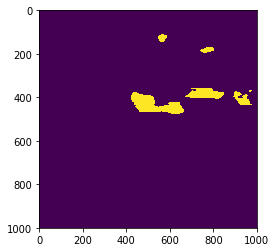

In [98]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
img = img4*255 
img = img.astype('uint8')
plt.imshow(img);plt.show()

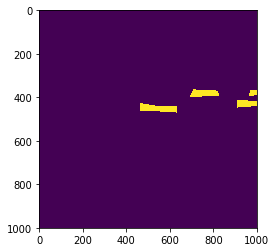

In [100]:
img = proba_map*255 
img = img.astype('uint8')
plt.imshow(img);plt.show()

In [70]:
np.max(predicted_y[:,:,:,0], axis = (1,2))

IndexError: too many indices for array

In [15]:
import pickle
data = pickle.load(open('data.pkl','r'))

In [16]:
data.keys()

['y', 'x', 'x1', 'y1']

In [17]:
x = data['x']
y = data['y']
x1 = data['x1']
y1 = data['y1']

In [18]:
data['x'].shape

(12, 1000, 1000, 3)

In [19]:
data['x1'].shape

(12, 1000, 1000, 3)

In [20]:
data['y1'].shape

(12, 1000, 1000, 2)

In [150]:
prediction = (predicted_y[:,:,:,0] >  0.5)

In [152]:
prediction.shape

(12, 1000, 1000)

In [81]:
x.shape

(12, 1000, 1000, 3)